In [172]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [173]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

In [805]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
tstamp = '1600397251'
#df = pd.read_sql("SELECT * FROM queries WHERE timestamp > 1600397251", con=connection)
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df = pd.concat([df,grav_df])
df.domain = df.domain.apply(lambda x: ' '.join(x.split('.')))

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.domain)

0        mobile pipe aria microsoft com
1        mobile pipe aria microsoft com
2                 telemetry dropbox com
3                        login live com
4                        edge skype com
                      ...              
83445          xn--localbitcins-vcd com
83446                   siambiznews com
83447                lp searchmulty com
83448                         usibw top
83449          leanproconsulting com br
Name: domain, Length: 112930, dtype: object


In [1021]:
def make_mask(x):
    y = np.zeros(100)
    y[:x] = 1
    return y

def make_multilabel(x):
    x_ = list(map(lambda xx: int(xx),x.split(' ')))
    y = np.zeros(100)
    y[range(len(x_))] = x_
    return y

In [1022]:
#import sentencepiece as spm

# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
#spm.SentencePieceTrainer.train('--input=domains.txt --model_prefix=m --vocab_size=5000')

# makes segmenter instance and loads the model file (m.model)
#sp = spm.SentencePieceProcessor()
#sp.load('m.model')


import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "yttm_ads.model"

# Generating random file with training data
# 10000 lines with 100 characters in each line
#n_lines = 10000
#n_characters = 100
#with open(train_data_path, "w") as fout:
#    for _ in range(n_lines):
#        print("".join([random.choice("abcd ") for _ in range(n_characters)]), file=fout)

# Generating random text
test_text = "".join([random.choice("abcde ") for _ in range(10000)])

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=500, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[64], [125], [73], [93], [86], [97], [], [54], [93], [54], [97], [], [48], [114], [93], [48], [], [64], [93], [45], [114], [125], [55], [125], [85], [69], [], [45], [125], [64]]
[['▁m'], ['▁o'], ['▁b'], ['▁i'], ['▁l'], ['▁e'], [], ['▁p'], ['▁i'], ['▁p'], ['▁e'], [], ['▁a'], ['▁r'], ['▁i'], ['▁a'], [], ['▁m'], ['▁i'], ['▁c'], ['▁r'], ['▁o'], ['▁s'], ['▁o'], ['▁f'], ['▁t'], [], ['▁c'], ['▁o'], ['▁m']]
mobile pipe aria microsoft com


In [389]:
df_ = df.loc[df.client=='192.168.0.147'].reset_index()
df_['timestamp'] = df_.timestamp.round(-3)
df_dom = df_.groupby(['timestamp','domain']).count().reset_index()

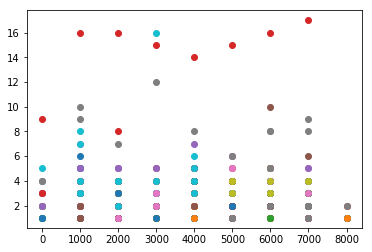

In [100]:
for dom in df_dom.domain.unique():
    df_dom_i = df_dom.loc[df_dom.domain==dom].reset_index()
    pl.plot(df_dom_i.timestamp.unique()-df_.timestamp.unique().min(),df_dom_i['index'],'o')

In [1023]:
format_df = df.groupby('timestamp').sum().reset_index()
format_df['domain'] = df.groupby('timestamp')['domain'].apply(lambda x: '|'.join(x)).reset_index()['domain']
format_df['domain_list'] = df.groupby('timestamp')['domain'].apply(lambda x: ','.join(x)).reset_index()['domain']
format_df['mask_count'] = df.groupby('timestamp')['domain'].apply(lambda x: len(x)).reset_index()['domain']
format_df['domain'] = format_df['domain'].apply(lambda x: ' '.join(x.split('.')))
format_df['blocked_chain'] = df.groupby('timestamp')['blocked'].apply(lambda x: ' '.join([str(int(i)) for i in x])).reset_index()['blocked']

In [1024]:
print(bpe.encode(list(format_df.domain.values[:4]), output_type=yttm.OutputType.SUBWORD))

[['▁mobile', '▁pipe', '▁aria', '▁microsoft', '▁com', '|', 'm', 'ob', 'ile', '▁pipe', '▁aria', '▁microsoft', '▁com'], ['▁telemetry', '▁dropbox', '▁com'], ['▁log', 'in', '▁live', '▁com', '|', 'edge', '▁s', 'k', 'yp', 'e', '▁com', '|', 'oc', 'sp', '▁apple', '▁com', '|', 'c', 'on', 'f', 'ig', '▁', 'edge', '▁s', 'k', 'yp', 'e', '▁com', '|', 'p', 'rod', '▁re', 'g', 'ist', 'r', 'ar', '▁s', 'k', 'yp', 'e', '▁com', '|', 'ap', 'i', '▁a', 's', 'm', '▁s', 'k', 'yp', 'e', '▁com'], ['▁ss-prod-ue1-notif-59', '▁aws', '▁adobess', '▁com']]


In [1025]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.text import Tokenizer
#tokenize = Tokenizer()

encoded_docs = pad_sequences(list(bpe.encode(list(format_df.domain.values), output_type=yttm.OutputType.ID)),100,padding='post')#map(sp.encode_as_ids,format_df.domain.values)),100,padding='post')
masks = np.array(list(map(make_mask,format_df.mask_count)))
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

In [1026]:
from tensorflow.keras.layers import Embedding,Dense,Input,Flatten,Concatenate,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam

In [1027]:
def test_model():
    input_domains = Input(shape=(100,))
    input_mask = Input(shape=(100,))
    embed = Embedding(501,64)(input_domains)
    dense1 = Dropout(0.2)(Dense(128,activation=None)(Flatten()(embed)))
    
    dense_mask = Dropout(0.2)(Dense(32,activation='relu')(input_mask))
    concat_dense = Concatenate()([dense1,dense_mask])
    dense_merge = Dense(100,activation='relu')(concat_dense)
    
    output = Dense(100,activation='sigmoid')(dense_merge)
    model = Model(inputs=[input_domains,input_mask],outputs=output)
    #SGD(learning_rate=1e-2)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [1028]:
tm = test_model()

In [1029]:
train,test = train_test_split(range(len(encoded_docs)))

In [1030]:
tm.fit([encoded_docs[train],masks[train]],labels[train],validation_data=([encoded_docs[test],masks[test]],labels[test]),epochs=5)

Train on 10280 samples, validate on 3427 samples
Epoch 1/5
10280/10280 [==============================] - 5s 512us/sample - loss: 0.0319 - accuracy: 0.9862 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 2/5
10280/10280 [==============================] - 4s 395us/sample - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 3/5
10280/10280 [==============================] - 4s 395us/sample - loss: 0.0036 - accuracy: 0.9986 - val_loss: 0.0040 - val_accuracy: 0.9986
Epoch 4/5
10280/10280 [==============================] - 4s 393us/sample - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 5/5
10280/10280 [==============================] - 4s 405us/sample - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0037 - val_accuracy: 0.9987


In [1031]:
ref_model = tf.keras.models.clone_model(tm)
ref_model.set_weights(tm.get_weights())

In [1040]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x):
        encoded_docs = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),100,padding='post').reshape(1,100)
        masks = np.array(make_mask(6)).reshape(1,100)
        return self.ml_model.predict([encoded_docs,masks])
        
mw = model_wrapper(ref_model,bpe)
mw.predict('abc.micro.com|lotsa.ver.com|google.com|server.org|bbc.news.co.uk')

array([[3.7527382e-03, 7.0586610e-01, 7.4772865e-01, 5.6327438e-01,
        5.5616885e-01, 5.5318505e-02, 3.7456751e-03, 6.5937638e-04,
        1.8945336e-04, 4.4190884e-04, 8.0412626e-04, 3.7804246e-04,
        1.3807416e-04, 5.2604079e-04, 7.6979399e-05, 2.9534101e-05,
        4.5746565e-05, 9.4473362e-06, 6.9350004e-05, 7.7188015e-06,
        6.4998865e-05, 7.9810619e-05, 7.6323748e-05, 5.1528215e-05,
        3.9935112e-06, 3.6954880e-06, 1.8298626e-05, 7.9840422e-05,
        1.5288591e-05, 1.3321638e-05, 2.7805567e-05, 2.6315451e-05,
        5.4240227e-06, 2.2679567e-05, 1.2218952e-06, 3.2782555e-06,
        1.1026859e-06, 4.1723251e-06, 3.1292439e-06, 5.3048134e-06,
        1.9073486e-06, 5.7339668e-05, 7.6591969e-06, 1.1920929e-06,
        1.7583370e-06, 1.1920929e-07, 1.2755394e-05, 0.0000000e+00,
        6.2584877e-07, 3.5881996e-05, 4.2021275e-06, 1.1593103e-05,
        1.9669533e-06, 2.1755695e-06, 6.7055225e-06, 4.0531158e-06,
        6.2584877e-07, 1.4603138e-06, 1.2516975e

In [71]:
masks = np.array(list(map(make_mask,format_df.mask_count)))

In [726]:
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

[0]
[0, 0, 0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[1, 0]
[1, 1]
[1]
[0, 0]
[0]
[1, 1, 0]
[1]
[0]
[1, 1]
[1]
[0]
[0]
[1, 1, 0, 0]
[0, 1]
[0, 0, 0]
[0]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0]
[1, 1]
[0]
[0, 1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 1, 0, 0]
[0, 1, 0]
[0]
[0, 0, 0, 0]
[1, 1]
[1]
[1, 1, 0]
[1]
[1, 1]
[1]
[0]
[1, 1]
[1]
[0]
[1, 1]
[1, 0]
[1]
[0]
[0]
[1, 1]
[0, 1]
[0, 1, 1, 1]
[0]
[0]
[1, 1]
[1]
[1, 1]
[1, 0]
[0]
[1, 1]
[1, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[1, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1, 0]
[1, 0]
[1, 1]
[0, 1]
[0, 0]
[1]
[0, 0, 0]
[0]
[1, 1]
[1]
[1]
[0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1, 0, 1, 0, 1]
[0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1, 1, 0, 0]
[0, 1]
[0]
[0, 0, 1, 1, 1]
[0]
[0]
[0]
[0]
[0]
[1, 1, 0]
[0, 1, 0]
[0, 1, 1]
[1]
[0]
[1, 1]
[0, 1]
[0]
[0, 0, 1, 0]
[1, 0, 0]
[0, 0, 0]
[0]
[1, 1]
[1, 0]
[1, 

[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[1, 1]
[1]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0, 0]
[0]
[0, 0]
[1]
[0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0, 0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 1, 0]
[0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0, 0, 1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1, 1]
[1, 1]
[0]
[0, 0, 0]
[1, 1]
[1]
[0]
[1, 1]
[0, 0]
[1]
[0]
[1, 1]
[0]
[1]
[0]
[0, 0]
[1, 1]

[1, 1, 0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[1, 0]
[0, 0]
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[1]
[0, 1]
[1, 0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[1]
[0, 0, 1, 0, 1, 1]
[1, 0, 1]
[0, 0, 0]
[0, 0]
[0]
[0]
[0, 1]
[1, 1]
[1, 0]
[0, 0]
[0]
[0]
[0]
[1, 1, 0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[0, 1]
[0, 1, 1]
[0, 1, 0]
[0]
[0, 1]
[0]
[0]
[1, 1, 1, 1]
[1]
[0, 0]
[0]
[0, 1, 1, 1, 1]
[0]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 0, 1]
[0]
[0, 1, 0]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1, 0]
[0]
[0]
[0]
[0, 0, 0]
[0, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[1]
[0, 0]
[0]
[0, 0

[0]
[0]
[0]
[0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0]
[0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 1, 1]
[1]
[0, 0]
[0]
[1]
[1, 1]
[0]
[1]
[0]
[1, 1]
[1]
[1]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[0]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[1]
[1]
[1]
[1, 1]
[1]
[0]
[0]
[1]
[0, 1]
[1]
[0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1, 0]
[1, 1, 1, 1, 1]
[0]
[0]
[1]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0, 1]
[1]
[0]
[1]
[1]
[1]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0]
[1]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0, 0]
[0, 0]
[1, 1, 

[0]
[1]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0, 0]
[0, 0, 0]
[0]
[1, 0]
[1, 0]
[0]
[0]
[0]
[0]
[1, 1, 1]
[0]
[0]
[1]
[0, 0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0, 0]
[1, 0]
[0]
[1, 1]
[0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1]
[1]
[1, 1, 0, 0, 1, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[1, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0]
[0, 0]
[1]
[0, 0, 0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1, 1]
[0]
[1]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[1, 0, 0]
[1, 1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0]
[0]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[0]
[0, 1]
[1]
[0]
[0]
[0]
[0]
[1, 1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0]
[1]
[1, 1]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1]
[0, 0]
[0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 1, 0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0, 0]
[0, 0]
[0]
[1]
[1]
[0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[1]
[1, 0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]


In [1042]:
predicted = np.where(tm.predict([encoded_docs[test],masks[test]])>0.5,1,0).astype(bool)
domain_lists = list(map(lambda x: x.split(','),format_df.domain_list.loc[test].values))
bad_domains = list(map(lambda x: np.array(x[0])[x[1][:len(x[0])]],zip(domain_lists,predicted)))

In [1043]:
bad_domains = [i[0] for i in bad_domains if len(i)>0]

In [1044]:
parsed_domain_data = df.loc[df.blocked==1].domain.unique()

In [1045]:
print(len(bad_domains))
[i for i in bad_domains if i not in parsed_domain_data]

1073


['eas3 msg t-mobile com',
 'stackoverflow com',
 'l3 aaxads com',
 'd19rpgkrjeba2z cloudfront net',
 'i ytimg com',
 'geo rlcdn com',
 'geomobileservices-pa googleapis com',
 'eas3 msg t-mobile com',
 'nodeny targetspot com',
 'app launchdarkly com',
 'scontent-iad3-1 cdninstagram com',
 'github com',
 'www google com',
 'stackpath bootstrapcdn com',
 'growth-pa googleapis com',
 'l3 aaxads com',
 'd19rpgkrjeba2z cloudfront net',
 'c aaxads com',
 'e9959 e9 akamaiedge net',
 'fedex tt omtrdc net',
 'config edge skype com',
 'api github com',
 'android googleapis com',
 'play itunes apple com edgesuite net',
 '771bbbb9d0449665d08228f83dfdb2f1 fp measure office com',
 'e11089 d akamaiedge net',
 'fonts googleapis com',
 'b thumbs redditmedia com',
 'people-service-prod trafficmanager net',
 'geomobileservices-pa googleapis com',
 'c aaxads com',
 'lh3 googleusercontent com',
 'qbk3fm yyjvimo com',
 'vidassets terminus services',
 'l3 aaxads com',
 '0 client-channel google com',
 'apple c

In [674]:
tf.keras.models.save_model(tm,'./dns_anhilator.h5')

In [1065]:
tm.optimizer.lr.assign(1e-4)
epsilon = 0.1
true_ct = 0
for i in range(400,1000):
    if i == 0:
        labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],labels_forward,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
        ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
    else:
        tm_probs = tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        ref_probs = ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        tm_entropy = -np.sum(tm_probs*np.log(tm_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        ref_entropy = -np.sum(ref_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        labels_forward = np.where(tm_probs>0.5,1,0)
        ref_labels = np.where(ref_probs>0.5,1,0)
        print('Entropy TM',tm_entropy)
        print('Entropy Ref',ref_entropy)
        print('Cross Entropy:',-np.sum(tm_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1]))))
        
        if np.random.rand() > epsilon:#tm_entropy > ref_entropy:
            candidate_labels = np.where(ref_probs>0.5,1,0)#labels_forward.copy()
        else:
            print('Epsilon!')
            candidates = np.argmin(masks[test][i:i+1])
            print(candidates)
            candidate_labels = np.array(list(map(lambda x: make_multilabel(' '.join([str(int(i)) for i in x])), np.random.randint(0,2,size=(1,candidates))))).reshape(1,100)
        print(np.array(format_df.loc[test].iloc[i].domain_list))#[candidate_labels.astype(bool).reshape(-1)])
        print(ref_labels[0][:10])
        print(candidate_labels[0][:10])
        #candidate_labels = np.where(labels_forward != ref_labels, labels_forward, ref_labels)
        true_ct += int(not (np.sum(ref_labels)==np.sum(candidate_labels)))
        print('Models diverge:',not (np.sum(ref_labels)==np.sum(candidate_labels)))
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],candidate_labels,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
    print(np.sum(labels_forward==ref_labels)/ref_labels.size)
    

Entropy TM 0.0005136738326519367
Entropy Ref 0.0037867963137722532
Cross Entropy: 0.00046860862842201736
www theringer com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 3.7492e-07 - accuracy: 1.0000 - val_loss: 1.0808e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0007292207442724467
Entropy Ref 0.003094778161650979
Cross Entropy: 0.0006943503200602071
app-measurement com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 140ms/sample - loss: 3.7739e-06 - accuracy: 1.0000 - val_loss: 2.3525e-07 - val_accuracy: 1.0000
1.0
Entropy TM 0.0002828360578484325
Entropy Ref 0.0023059409767228747
Cross Entropy: 0.00025552126420832957
gspe35-ssl ls apple com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==========

1/1 [==============================] - 0s 129ms/sample - loss: 0.1394 - accuracy: 0.9900 - val_loss: 5.7309e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.16161236330421502
Entropy Ref 0.17215401238539388
Cross Entropy: 0.1585499946457265
fonts googleapis com,click samsonite com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 2.3883e-04 - accuracy: 1.0000 - val_loss: 1.7284e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011416948009518674
Entropy Ref 0.017508271298976245
Cross Entropy: 0.01130082069543494
static-asm-skype trafficmanager net,1180c ec azureedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 7.0096e-06 - accuracy: 1.0000 - val_loss: 4.1626e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.00139881804249979
Entropy Ref 0.00398921548737955

1/1 [==============================] - 0s 119ms/sample - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.1489e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.001243554689976956
Entropy Ref 0.002766328319385559
Cross Entropy: 0.0012721099249387898
time-osx g aaplimg com,112 0 168 192 in-addr arpa
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 5.8945e-07 - accuracy: 1.0000 - val_loss: 6.4131e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.005542817113440755
Entropy Ref 0.008295410862494933
Cross Entropy: 0.0065381087136406075
Epsilon!
2
p31-keyvalueservice icloud com,p31-escrowproxy icloud com
[0 0 0 0 0 0 0 0 0 0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 0.0879 - accuracy: 0.9900 - val_loss: 0.0047 - val_accuracy: 1.0000
1.0
Entropy TM 0.37044280460071655
Entr

1/1 [==============================] - 0s 120ms/sample - loss: 1.7046e-06 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
1.0
Entropy TM 0.36968269503794965
Entropy Ref 0.014236755922323822
Cross Entropy: 2.5374880496714254
comet api hbo com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 154ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9800
1.0
Entropy TM 0.2780016036172953
Entropy Ref 0.42695688716629593
Cross Entropy: 0.19677743003365145
tracker samplicio us,img3 hulu com,img hulu com,doppler hulu com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 130ms/sample - loss: 9.3068e-04 - accuracy: 1.0000 - val_loss: 5.9906e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.038324254049223974
Entropy Ref 0.052617872156113195
Cross Entropy: 0.0569514

1.0
Entropy TM 0.14957074241307278
Entropy Ref 0.01547742389471495
Cross Entropy: 0.27106880059565364
23-courier push apple com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 3.4888e-04 - accuracy: 1.0000 - val_loss: 1.0311e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.008034416716627713
Entropy Ref 0.0030936309948274942
Cross Entropy: 0.010326214278154765
app-measurement com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 141ms/sample - loss: 1.0992e-05 - accuracy: 1.0000 - val_loss: 3.7824e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.14043509002371746
Entropy Ref 0.04114286639552612
Cross Entropy: 0.26212621089068144
inbox google com,peoplestack-pa googleapis com,outlook office365 com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samp

1.0
Entropy TM 0.48132261427566075
Entropy Ref 0.4183185214260548
Cross Entropy: 0.5757498205488019
2-01-3073-0019 cdx cedexis net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
1.0
Entropy TM 0.29601697067864113
Entropy Ref 0.03733285212881858
Cross Entropy: 0.7431445135975904
taskassist-pa clients6 google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 7.6953e-04 - accuracy: 1.0000 - val_loss: 1.0225e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.05083129154706977
Entropy Ref 0.01051648975536829
Cross Entropy: 0.07611339869750199
lcs-cops adobe io,lcs-robs adobe io
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/

1/1 [==============================] - 0s 121ms/sample - loss: 3.9731e-05 - accuracy: 1.0000 - val_loss: 1.6315e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.08076154079444534
Entropy Ref 0.018456281003712445
Cross Entropy: 0.12920131364262294
i ytimg com,youtube-ui l google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 3.0048e-04 - accuracy: 1.0000 - val_loss: 4.1136e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.025627838132940367
Entropy Ref 0.008517103579113875
Cross Entropy: 0.03182902864791359
zpns-va zoom us
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 141ms/sample - loss: 3.2881e-05 - accuracy: 1.0000 - val_loss: 1.3644e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011196022320543323
Entropy Ref 0.007123336492918983
Cross Entropy: 0.012707606711188809
smo

1/1 [==============================] - 0s 121ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 7.6024e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0070626308305759685
Entropy Ref 0.004716850754511792
Cross Entropy: 0.00777804854019255
zpns zoom us
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 135ms/sample - loss: 2.0331e-05 - accuracy: 1.0000 - val_loss: 8.2097e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.044786410776573686
Entropy Ref 0.02159819085787789
Cross Entropy: 0.054108949786420384
smooth pro17 lln cdn hbomax com,smooth pro17 lln cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 4.3822e-05 - accuracy: 1.0000 - val_loss: 1.8687e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.014614648188138464
Entropy Ref 0.008237927370326796
Cross Entropy: 0

1/1 [==============================] - 0s 111ms/sample - loss: 0.1351 - accuracy: 0.9200 - val_loss: 1.3948e-04 - val_accuracy: 1.0000
0.93
Entropy TM 0.07591930300729302
Entropy Ref 0.033237034065830694
Cross Entropy: 0.10873533493839742
collector-pxhyx10rg3 px-cloud net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 157ms/sample - loss: 2.7210e-04 - accuracy: 1.0000 - val_loss: 2.2148e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.016040052226187172
Entropy Ref 0.006380540288911484
Cross Entropy: 0.01997335832236622
xmpp006 hpeprint com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 136ms/sample - loss: 1.1124e-05 - accuracy: 1.0000 - val_loss: 3.5137e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02233642741866105
Entropy Ref 0.005573473532038046
Cross Entropy: 0.029890096500524266
ss-p

1.0
Entropy TM 0.06361922401379537
Entropy Ref 0.009196012141431998
Cross Entropy: 0.09894777738622026
www inverse com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 1.3487e-04 - accuracy: 1.0000 - val_loss: 5.2803e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.031585414000690516
Entropy Ref 0.005574637231877781
Cross Entropy: 0.04505719288867274
ss-prod-ue1-notif-59 aws adobess com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 138ms/sample - loss: 2.1218e-04 - accuracy: 1.0000 - val_loss: 4.1333e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.025735600015854693
Entropy Ref 0.003970886509378352
Cross Entropy: 0.03725442293102003
Epsilon!
1
swcdn g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 sa

1/1 [==============================] - 0s 105ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2054e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011166891923783303
Entropy Ref 0.0029908607724187966
Cross Entropy: 0.013486675632685775
play google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 4.8395e-06 - accuracy: 1.0000 - val_loss: 7.6731e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04740742272194765
Entropy Ref 0.0148880053663951
Cross Entropy: 0.05928198394569366
www hollywoodreporter com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 137ms/sample - loss: 2.4734e-04 - accuracy: 1.0000 - val_loss: 1.9579e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.08188692566258585
Entropy Ref 0.00303194144048082
Cross Entropy: 0.18612527973582396
preview redd it
[0 0

1.0
Entropy TM 0.09543170751209966
Entropy Ref 0.27908584974402223
Cross Entropy: 0.06117352045139681
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com,gsas apple com,gsas apple com,gsas apple com akadns net
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 1.6255e-04 - accuracy: 1.0000 - val_loss: 1.1505e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.010902156181687593
Entropy Ref 0.003203039151572046
Cross Entropy: 0.012521264527732463
gateway fe apple-dns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 154ms/sample - loss: 1.8555e-05 - accuracy: 1.0000 - val_loss: 3.2309e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.023539997488037787
Entropy Ref 0.008758826154675233
Cross Entropy: 0.027075372104750178
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0

0.99
Entropy TM 0.6337121967421886
Entropy Ref 0.43845895097215803
Cross Entropy: 2.5212325051654294
p tvpixel com,secure-gl imrworldwide com,t2 hulu com
[0 1 1 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3618e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.012409468910976695
Entropy Ref 0.003215919904190805
Cross Entropy: 0.014484223937441391
gateway fe apple-dns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 9.3071e-06 - accuracy: 1.0000 - val_loss: 3.7225e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.028467178262908167
Entropy Ref 0.004415751016952499
Cross Entropy: 0.03908569834508405
www google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples

1/1 [==============================] - 0s 131ms/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.0435e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.1603195834770478
Entropy Ref 0.07302443538765575
Cross Entropy: 0.20583002455299335
Epsilon!
2
play hulu com,http-e-darwin hulustream com
[0 0 0 0 0 0 0 0 0 0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0300 - accuracy: 0.9900 - val_loss: 1.7239e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.015649874452795462
Entropy Ref 0.005014507425625996
Cross Entropy: 0.01774865110413
www reddit com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 3.0519e-05 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
1.0
Entropy TM 0.3061666085399783
Entropy Ref 0.00605091556066109
Cross Entropy: 1.2721218929515494

1.0
Entropy TM 0.02648314760201233
Entropy Ref 0.016127481084841164
Cross Entropy: 0.029490580709142077
col eum-appdynamics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 6.1526e-05 - accuracy: 1.0000 - val_loss: 3.6612e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.027089842068189676
Entropy Ref 0.005590512865775457
Cross Entropy: 0.034180161430148764
ss-prod-ue1-notif-59 aws adobess com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 5.6740e-05 - accuracy: 1.0000 - val_loss: 3.7322e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02898425821981691
Entropy Ref 0.007861544905814984
Cross Entropy: 0.03833182708098014
ocsp-lb apple com akadns net,e673 dsce9 akamaiedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 s

1/1 [==============================] - 0s 109ms/sample - loss: 1.4595e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9900
1.0
Entropy TM 0.045605149066328544
Entropy Ref 0.25189394883302396
Cross Entropy: 0.38538373951274035
geomobileservices-pa googleapis com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 1.6247e-04 - accuracy: 1.0000 - val_loss: 2.0125e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.016577490643920546
Entropy Ref 0.0023940541196130175
Cross Entropy: 0.022871417434057288
time-osx g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 2.6824e-05 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9600
1.0
Entropy TM 8.33275820277051
Entropy Ref 5.699712436716659
Cross Entropy: 16.753322603870853
ad doublecl

1/1 [==============================] - 0s 228ms/sample - loss: 7.8622e-05 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
1.0
Entropy TM 0.4234277559789857
Entropy Ref 0.0520116255268959
Cross Entropy: 1.1736461767077941
Epsilon!
2
www bbc com,www datadoghq com
[0 0 0 0 0 0 0 0 0 0]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.0784 - accuracy: 0.9800 - val_loss: 2.0352e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.09329188233535694
Entropy Ref 0.045468955905244954
Cross Entropy: 0.12939370791494745
safebrowsing googleapis com,reports crashlytics com
[0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 3.0340e-04 - accuracy: 1.0000 - val_loss: 8.0231e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.2660130646967152
Entropy Ref 0.22258473028667022
Cross

1/1 [==============================] - 0s 120ms/sample - loss: 1.5496e-04 - accuracy: 1.0000 - val_loss: 6.9167e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04094999271444978
Entropy Ref 0.005486849068237655
Cross Entropy: 0.05839292290910587
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 142ms/sample - loss: 3.1747e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
1.0
Entropy TM 0.264344535232024
Entropy Ref 0.03068567850626233
Cross Entropy: 0.6038761707769426
ecs wup shop nintendo net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
1.0
Entropy TM 0.762593129013319
Entropy Ref 0.2933440566547081
Cross Entropy: 1.2915993723978916
client dropbox com,e6858 dsce

1.0
Entropy TM 0.23789712508048133
Entropy Ref 0.07614533904328336
Cross Entropy: 0.3689222235869514
27633e09c04141cc9e2cff576309c0c8 safeframe googlesyndication com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 146ms/sample - loss: 8.9054e-04 - accuracy: 1.0000 - val_loss: 1.5452e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07610276199602717
Entropy Ref 0.0041926968987151415
Cross Entropy: 0.14008912608489427
1hac6me yyjvimo com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 137ms/sample - loss: 2.7970e-04 - accuracy: 1.0000 - val_loss: 3.4759e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.13929093889380487
Entropy Ref 0.0029889160523388063
Cross Entropy: 0.3475896972860329
notify adobe io
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on

1.0
Entropy TM 0.012936483099550422
Entropy Ref 0.0030934772813463562
Cross Entropy: 0.015302940549307593
guzzoni-apple-com v aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 7.0406e-05 - accuracy: 1.0000 - val_loss: 8.3625e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.056483941393188616
Entropy Ref 0.012873111065589062
Cross Entropy: 0.08189122709692177
t1-1 p-cdn us,t1-1 p-cdn us,e17437 dscb akamaiedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 4.0030e-04 - accuracy: 1.0000 - val_loss: 3.3826e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02754140410152844
Entropy Ref 0.004138585549595173
Cross Entropy: 0.03657612001469891
www googleapis com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, v

1.0
Entropy TM 0.25647651888752
Entropy Ref 0.009025619360256306
Cross Entropy: 0.7021324348410284
dms licdn com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0892e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.059488512073833745
Entropy Ref 0.003968528311942692
Cross Entropy: 0.09938140129896882
swcdn g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 4.1952e-04 - accuracy: 1.0000 - val_loss: 8.1891e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04867883168107095
Entropy Ref 0.008760126701813167
Cross Entropy: 0.06639426868380167
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [=========================

1/1 [==============================] - 0s 123ms/sample - loss: 7.0411e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
1.0
Entropy TM 0.6815173976195971
Entropy Ref 0.3895928865790752
Cross Entropy: 1.720981675315478
youtube-ui l google com,star-mini c10r facebook com,getpocket com,e49 g akamaiedge net,www alteryx com cdn cloudflare net,www vulture com,noom 8utb net,unbouncepages com,www glamour com,www google com,www gstatic com,encrypted-tbn0 gstatic com,ocsp-lb apple com akadns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.8182e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02384442695981349
Entropy Ref 0.005823363743704233
Cross Entropy: 0.02803447154452082
browser pipe aria microsoft com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [===

1/1 [==============================] - 0s 120ms/sample - loss: 5.6086e-05 - accuracy: 1.0000 - val_loss: 4.2779e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.029228848909003072
Entropy Ref 0.003326218192271788
Cross Entropy: 0.04147158052727316
imap gmail com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 7.6133e-05 - accuracy: 1.0000 - val_loss: 2.2430e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.0940445993555158
Entropy Ref 0.002647117853452715
Cross Entropy: 0.242243164582085
polka typekit com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 3.4018e-04 - accuracy: 1.0000 - val_loss: 8.1940e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.051465376268430015
Entropy Ref 0.005575803628225582
Cross Entropy: 0.07749225049548882
ss-prod-ue1-notif-59 aws a

1.0
Entropy TM 0.024717856088908842
Entropy Ref 0.005486739343507751
Cross Entropy: 0.030575927937281165
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 1.4897e-04 - accuracy: 1.0000 - val_loss: 4.1343e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.029376877396552228
Entropy Ref 0.0087511601146691
Cross Entropy: 0.03594597417375087
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 7.6956e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
1.0
Entropy TM 0.31788887579799396
Entropy Ref 0.012554836723953203
Cross Entropy: 1.1119833345616565
config edge skype com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==========

1/1 [==============================] - 0s 119ms/sample - loss: 5.6179e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9900
1.0
Entropy TM 0.292100953950497
Entropy Ref 0.27683194266665684
Cross Entropy: 0.9578446720739259
b i instagram com,app launchdarkly com
[0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.5567e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.05687800424417519
Entropy Ref 0.03937077113644828
Cross Entropy: 0.06357013567475239
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 3.8306e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
1.0
Entropy TM 0.3643261865414582
Entropy Ref 0.2747063849901914
Cross Entropy: 0.47125

1/1 [==============================] - 0s 117ms/sample - loss: 3.7851e-05 - accuracy: 1.0000 - val_loss: 2.6265e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.021113454799654468
Entropy Ref 0.0029926494717944377
Cross Entropy: 0.031037303747530817
play google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 1.5923e-05 - accuracy: 1.0000 - val_loss: 4.2936e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.21182494258275675
Entropy Ref 0.12276402154394178
Cross Entropy: 0.2732603055470491
Epsilon!
7
weather-data apple com,weather-data apple com,apple-finance query yahoo com,apple-finance query yahoo com,a2047 dscb akamai net,a2047 dscb akamai net,geo-applefinance-cache internal query g03 yahoodns net
[0 0 0 0 0 0 0 0 0 0]
[1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 136ms/sample - l

1/1 [==============================] - 0s 121ms/sample - loss: 1.4416e-04 - accuracy: 1.0000 - val_loss: 1.4230e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.06573370349962648
Entropy Ref 0.0019289399554104048
Cross Entropy: 0.15707738970163193
112 0 168 192 in-addr arpa
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 4.0166e-04 - accuracy: 1.0000 - val_loss: 1.5341e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07861595460383464
Entropy Ref 0.007627879433038896
Cross Entropy: 0.15938867182451483
play itunes apple com,a2047 dscb akamai net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 7.1459e-04 - accuracy: 1.0000 - val_loss: 5.4796e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.03736483691311009
Entropy Ref 0.0043309015194445835
Cross Entropy: 0.060

1.0
Entropy TM 0.0075160467420022
Entropy Ref 0.003616613547905985
Cross Entropy: 0.00998467046305052
telemetry dropbox com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 187ms/sample - loss: 5.4871e-06 - accuracy: 1.0000 - val_loss: 1.2718e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07620399780113894
Entropy Ref 0.03936952643008893
Cross Entropy: 0.09412570656308178
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 153ms/sample - loss: 2.2217e-04 - accuracy: 1.0000 - val_loss: 1.6662e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.014726662289766563
Entropy Ref 0.00550986560551691
Cross Entropy: 0.016247043550546
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 sam

1/1 [==============================] - 0s 118ms/sample - loss: 3.1831e-05 - accuracy: 1.0000 - val_loss: 2.9186e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.11817863509194741
Entropy Ref 0.010378861148869125
Cross Entropy: 0.24636268875446085
discourse pi-hole net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 3.6212e-04 - accuracy: 1.0000 - val_loss: 3.3149e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.023840902577405662
Entropy Ref 0.003032801096365581
Cross Entropy: 0.03682145971866472
www linkedin com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 138ms/sample - loss: 1.4617e-05 - accuracy: 1.0000 - val_loss: 7.3836e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.006691119964600502
Entropy Ref 0.0036198366095651505
Cross Entropy: 0.008978455958073098
telemetry dropb

In [1069]:
bpe.encode(['test'])

[[69, 221]]

In [153]:
tm = tf.keras.models.clone_model(ref_model)

In [324]:
labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)

In [325]:
labels_forward,ref_labels

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [125]:
b = np.array(list(map(sp.encode_as_ids,format_df.domain.values)))

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [126]:
a = np.zeros((len(format_df.domain.values),5000))

In [127]:
for i,b_ in enumerate(b):
    a[i][b_] = 1

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca_model = PCA(n_components=2).fit_transform(a)

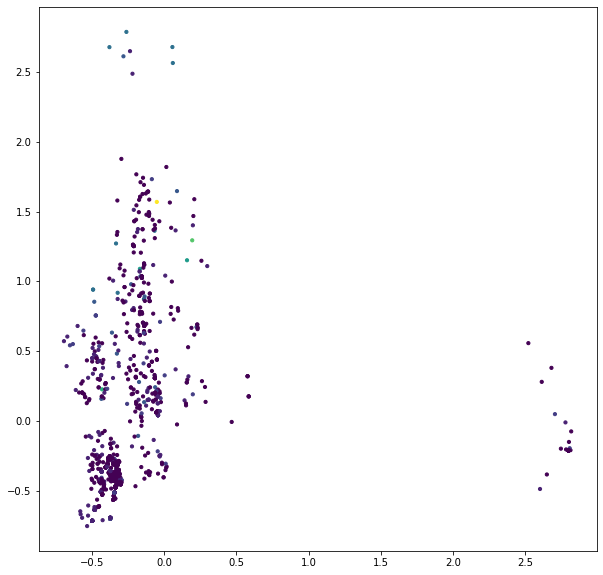

In [130]:
total_blocked = format_df.blocked_chain.apply(lambda x: sum([float(i) for i in x.split(' ')]))

pl.figure(figsize=(10,10))
pl.scatter(pca_model[:,0],pca_model[:,1],s=10,c=total_blocked)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  3.,  2.,  1.,  6.,  4.,  5.,  6.,  1.,  5.,  9.,  7.,
         5.,  9.,  9.,  6., 22., 12., 18., 17., 19., 26., 22., 31., 21.,
        29., 31., 29., 36., 22., 34., 25., 40., 23., 33., 30., 28., 29.,
        26., 32., 31., 24., 16., 15., 28., 18., 18., 20., 13., 13.,  6.,
         7., 10.,  3.,  7., 10., 11.,  5.,  3.,  2.,  2.,  5.,  2.,  1.,
         2.,  3.,  3.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.31646784, 0.32032306, 0.32417829, 0.32803351, 0.33188874,
        0.33574397, 0.33959919, 0.34345442, 0.34730964, 0.35116487,
        0.3550201 , 0.35887532, 0.36273055, 0.36658577, 0.370441  ,
        0.37429623, 0.37815145, 0.38200668, 0.3858619 , 0.38971713,
        0.39357236, 0.39742758, 0.40128281, 0.40513804, 0.40899326,
        0.41284849, 0.41670371, 0.42055894, 0.42441417, 0.42826939,
        0.43212462, 0.4359

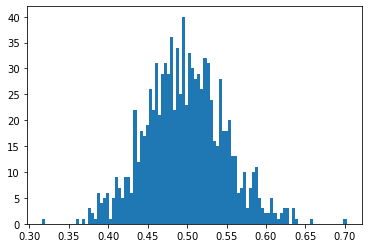

In [321]:
pl.hist(np.random.normal(0.5,scale=0.05,size=1000),bins=100)

In [694]:
format_df.timestamp[0].round(-1)

1600736340.0

In [809]:
encoded = pad_sequences(bpe.encode(list(df.domain.values), output_type=yttm.OutputType.ID),100,padding='post')
#embeds = tm.layers[2](pad_sequences(bpe.encode(list(df.domain.values), output_type=yttm.OutputType.ID),100,padding='post'))

In [810]:
sdm = test_model()
masks_sdm = np.array(list(map(make_mask,len(train)*[1])))
sdm.fit([encoded[train],masks_sdm],tf.keras.utils.to_categorical(df.blocked.values[train],100),epochs=10)

Train on 10280 samples
Epoch 1/10
10280/10280 [==============================] - 5s 451us/sample - loss: 0.0255 - accuracy: 0.9883
Epoch 2/10
10280/10280 [==============================] - 4s 364us/sample - loss: 9.7545e-04 - accuracy: 0.9997
Epoch 3/10
10280/10280 [==============================] - 4s 359us/sample - loss: 3.9267e-04 - accuracy: 0.9999
Epoch 4/10
 1120/10280 [==>...........................] - ETA: 3s - loss: 1.7258e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [851]:
embeds = mid.predict(encoded[train])
embeds_test = mid.predict(encoded[test])

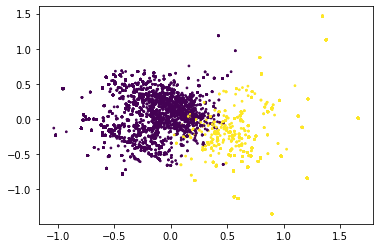

In [852]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2).fit(embeds)
pca_data = pca_model.transform(embeds)
pca_test = pca_model.transform(embeds_test)
pl.scatter(pca_data[:,0],pca_data[:,1],s=3,c=df.blocked.values[train])

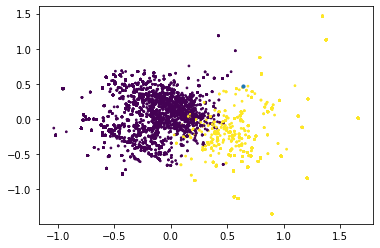

In [878]:
pl.scatter(pca_data[:,0],pca_data[:,1],s=3,c=df.blocked.values[train])
test = pca_model.transform(mid.predict(pad_sequences(bpe.encode(['ads server our friends'], output_type=yttm.OutputType.ID),100,padding='post')))
pl.scatter(test[:,0],test[:,1],s=10)

In [897]:
from sklearn.metrics.pairwise import cosine_similarity
test_case = mid.predict(pad_sequences(bpe.encode(['XXXXXXXX cloudfront net'], output_type=yttm.OutputType.ID),100,padding='post'))

train_labels = np.array(df.blocked.values[train])
good_labels = train_labels == 0
bad_labels = train_labels == 1

print(cosine_similarity(test_case,embeds[bad_labels,:].mean(axis=0).reshape(1,-1)),
cosine_similarity(test_case,embeds[good_labels,:].mean(axis=0).reshape(1,-1)))

[[0.7836937]] [[0.8133749]]


In [906]:
def test_model2():
    input_domains = Input(shape=(100,))
    embed = Embedding(501,64)(input_domains)
    dense1 = Dropout(0.2)(Dense(128,activation=None)(Flatten()(embed)))
    dense2 = Dropout(0.2)(Dense(128,activation='relu')(dense1))
    
    output = Dense(2,activation='softmax')(dense2)
    model = Model(inputs=input_domains,outputs=output)
    #SGD(learning_rate=1e-2)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [913]:
tm2 = test_model2()
train,test = train_test_split(range(len(encoded)))
tm2.fit(encoded[train],tf.keras.utils.to_categorical(df.blocked.values[train],2),epochs=10)

Train on 84697 samples
Epoch 1/10
84697/84697 [==============================] - 31s 369us/sample - loss: 0.1199 - accuracy: 0.9607
Epoch 2/10
84697/84697 [==============================] - 33s 388us/sample - loss: 0.0650 - accuracy: 0.9793
Epoch 3/10
84697/84697 [==============================] - 33s 386us/sample - loss: 0.0517 - accuracy: 0.9828
Epoch 4/10
84697/84697 [==============================] - 32s 376us/sample - loss: 0.0440 - accuracy: 0.9859
Epoch 5/10
84697/84697 [==============================] - 32s 373us/sample - loss: 0.0378 - accuracy: 0.9876
Epoch 6/10
84697/84697 [==============================] - 32s 374us/sample - loss: 0.0331 - accuracy: 0.9891
Epoch 7/10
84697/84697 [==============================] - 32s 376us/sample - loss: 0.0289 - accuracy: 0.9905
Epoch 8/10
84697/84697 [==============================] - 32s 377us/sample - loss: 0.0271 - accuracy: 0.9913
Epoch 9/10
84697/84697 [==============================] - 32s 377us/sample - loss: 0.0236 - accuracy: 0.9

In [1041]:
b = ['inbox google com','lnkd demdex net','star-mini c10r facebook com','support apple com','mediaserver-cont-dc6-2-v4v6 pandora com',
'www redditmedia com','adsabs harvard edu','click e1 victoriassecret com','mi victoriassecret com','discussions apple com edgekey net',
'emoji redditmedia com','rte stage evernote com','i redd it','reddit com','ios-tuner pandora com','v redd it',
'reddit map fastly net','firebaseremoteconfig googleapis com','beacon dropbox com','graph facebook com',
    'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com','content analytics arxiv org','smooth pro17 cf cdn hbomax com']
for b_ in b:
    pred = tm2.predict(pad_sequences(bpe.encode([b_], output_type=yttm.OutputType.ID),100,padding='post'))
    print(b_,np.argmax(pred),pred[0,1])

inbox google com 0 3.1780994e-05
lnkd demdex net 1 0.7639862
star-mini c10r facebook com 0 8.226162e-14
support apple com 0 1.4645105e-08
mediaserver-cont-dc6-2-v4v6 pandora com 0 9.5617374e-17
www redditmedia com 0 2.5676677e-06
adsabs harvard edu 1 1.0
click e1 victoriassecret com 0 0.00092587346
mi victoriassecret com 0 0.30783212
discussions apple com edgekey net 1 0.99937123
emoji redditmedia com 0 0.0022681537
rte stage evernote com 1 0.9999995
i redd it 0 4.588377e-09
reddit com 0 1.4324015e-06
ios-tuner pandora com 1 0.5871561
v redd it 0 1.4439924e-09
reddit map fastly net 0 2.6434278e-11
firebaseremoteconfig googleapis com 0 1.4254654e-06
beacon dropbox com 0 0.02766018
graph facebook com 0 0.3501229
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com 1 1.0
content analytics arxiv org 1 0.9984402
smooth pro17 cf cdn hbomax com 0 7.1184217e-20


In [1009]:
tm2.fit(pad_sequences(bpe.encode(['aws-cluster server com'], output_type=yttm.OutputType.ID),100,padding='post'),tf.keras.utils.to_categorical([1],2))

Train on 1 samples
1/1 [==============================] - 0s 44ms/sample - loss: 0.0000e+00 - accuracy: 1.0000


In [1010]:
pred = tm2.predict(pad_sequences(bpe.encode(['ads aws-cluster server com'], output_type=yttm.OutputType.ID),100,padding='post'))
print(pred)

[[2.4799988e-08 1.0000000e+00]]


In [1013]:
tf.keras.layers.Attention?